In [4]:
from dataclasses import dataclass
import os
from pathlib import Path
from plyfile import PlyData
import numpy as np

experiment = Path(
    '/home/aq85800/NewVolume/gsplat/method/mcmc/cloud+small+blackbg+200mocap_bogusorange32e3_correctcams/colmap_47')
experiment_pretty_name = Path('__'.join(experiment.parts[-4:]))
os.makedirs(experiment_pretty_name,exist_ok=True)

ply = sorted(
    (experiment/"ply").glob('point_cloud_*.ply'),
    key=lambda f: f.stat().st_mtime,
    reverse=True
)[0]

plydata = PlyData.read(ply)
xyz = np.array([plydata['vertex'][d]
               for d in ['x', 'y', 'z']]).T  # [N x (x,y,z)]
print(xyz)

# extend box so that the gaussian is on aabb's outer edge
aabb_min = np.min(xyz, 0) * (1+1e-3)
aabb_max = np.max(xyz, 0) * (1+1e-3)
aabb_n_cells = np.array([2,2,1]) * 64
aabb_cell_size = (aabb_max-aabb_min)/aabb_n_cells
print(np.vstack((aabb_min, aabb_max, aabb_cell_size)))

voxel_ids = np.floor((xyz - aabb_min) / aabb_cell_size).astype(int)
print(voxel_ids)

voxels = np.zeros(aabb_n_cells, dtype=np.float64)
for i,j,k in voxel_ids:
    voxels[i,j,k] += 1
assert voxels.sum() == xyz.shape[0], 'Gaussian counting error'
print(voxels)

min=voxels.min()
max=voxels.max()


[[ 0.00192443  0.00262308  0.39646584]
 [-0.00208478  0.00797046  0.3950145 ]
 [-0.06771202 -0.15331948  0.42103451]
 ...
 [-0.0238343  -0.13401541  0.43726534]
 [ 0.2043802  -0.06815616  0.43754172]
 [ 0.00500306  0.1539577   0.43169436]]
[[-0.85243464 -0.6023317   0.18192086]
 [ 1.20857739  0.86254233  0.51922333]
 [ 0.01610166  0.01144433  0.00527035]]
[[53 52 40]
 [52 53 40]
 [48 39 45]
 ...
 [51 40 48]
 [65 46 48]
 [53 66 47]]
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ..

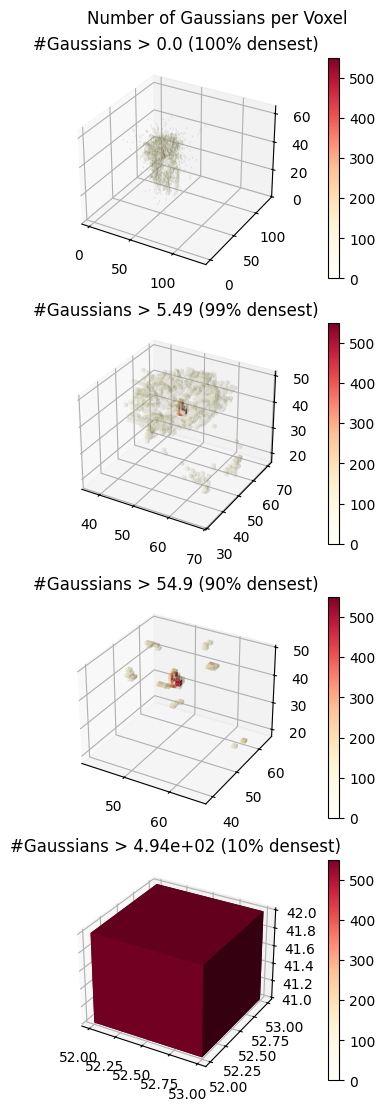

In [5]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import seaborn as sb


def alpha_gradient(cmap, lut, amin, amax):
    original = plt.get_cmap(cmap)(np.linspace(0,1,lut))
    alphas = np.linspace(amin, amax, num=lut)
    original[...,3] = alphas
    return ListedColormap(original)


alpha_grad_cmap = alpha_gradient('YlOrRd', 128, .1, 1.)
blend = (voxels - min)/(max-min)
faces = alpha_grad_cmap(blend)

densest_visibilities = [1.,.99,.9,.1]

fig = plt.figure(figsize=(8.5,11))
fig.set_layout_engine('compressed')
fig.suptitle("Number of Gaussians per Voxel")

axs=fig.subplots(nrows=len(densest_visibilities),subplot_kw={"projection":'3d'})
for densest_visibility,ax in zip(densest_visibilities,axs):
    fig.colorbar(ScalarMappable(norm=Normalize(vmin=min,vmax=max), cmap=alpha_grad_cmap),ax=ax)
    vis_min = (1-densest_visibility) * (max-min) + min
    _=ax.set_title(f"#Gaussians > {vis_min:.3} ({densest_visibility:.0%} densest)")
    _=ax.voxels(filled=voxels>vis_min, facecolors=faces)

fig.savefig(experiment_pretty_name/'3d.svg')


/tmp/ipykernel_558181/1865984295.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


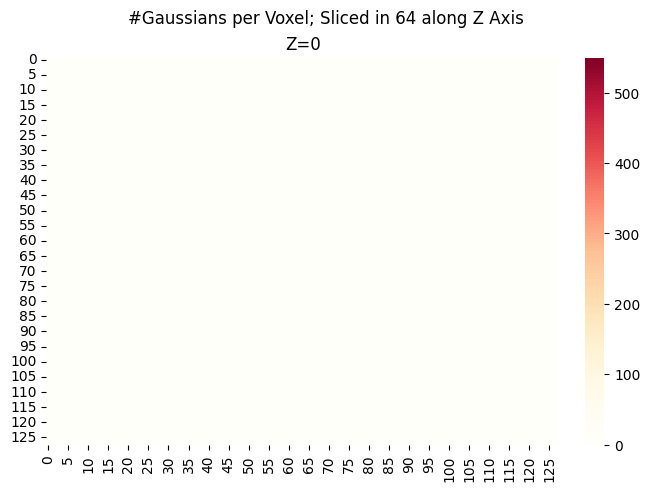

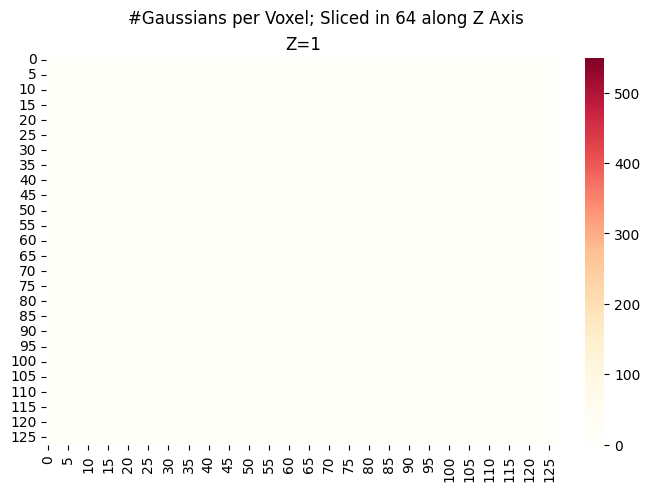

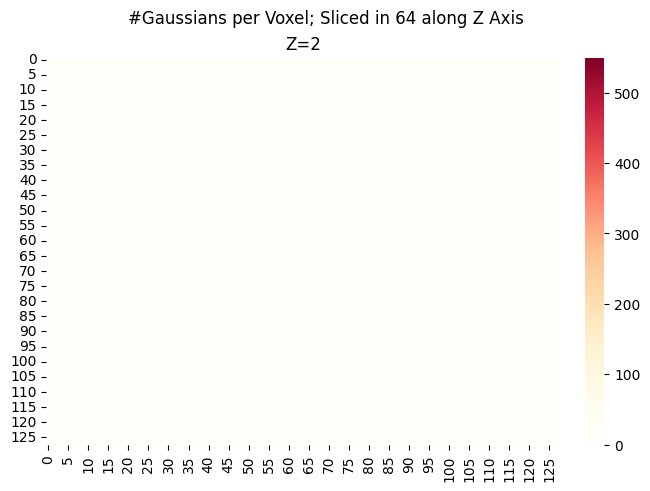

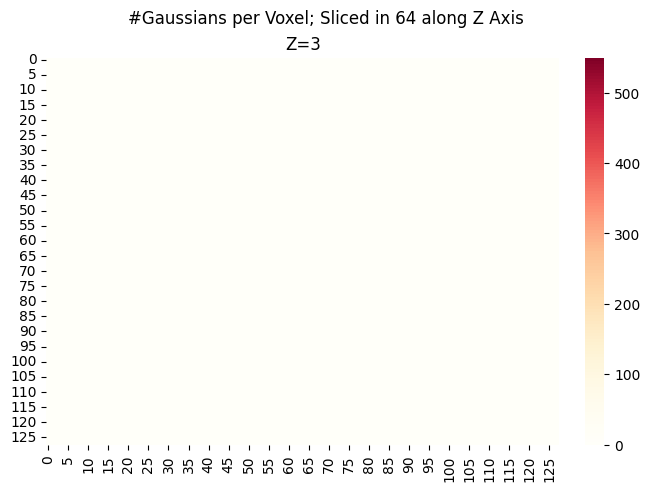

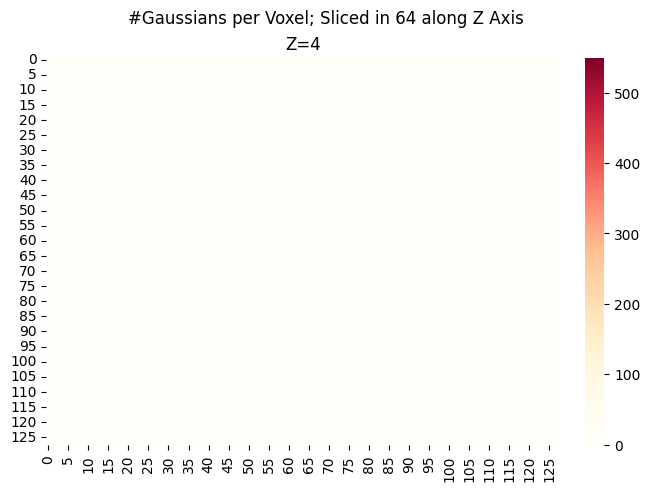

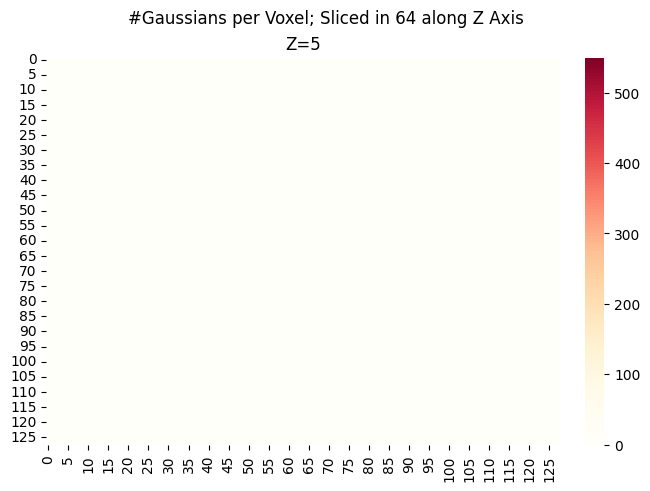

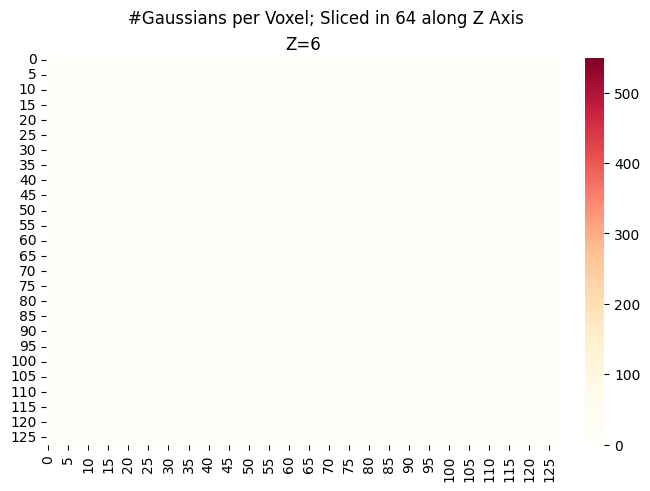

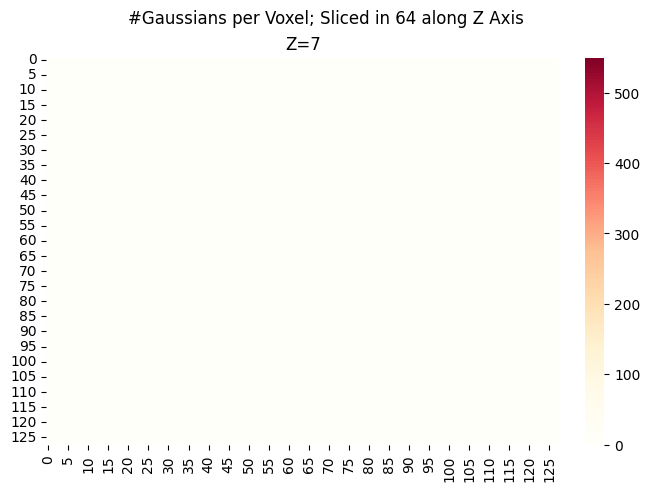

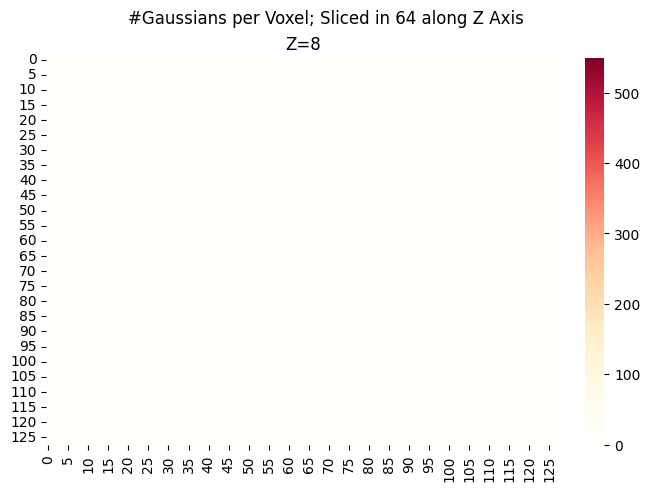

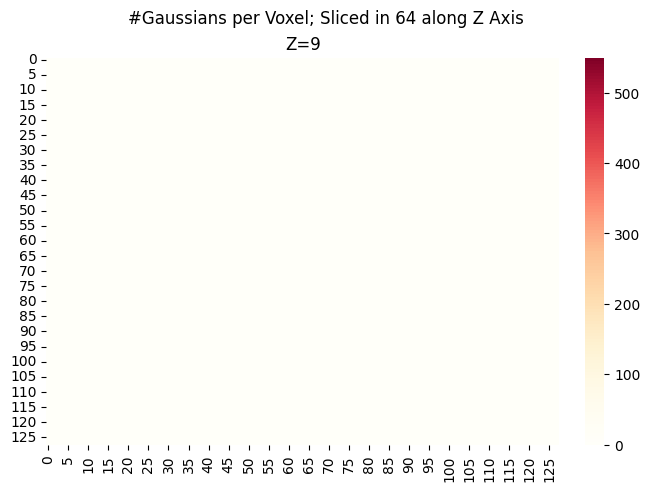

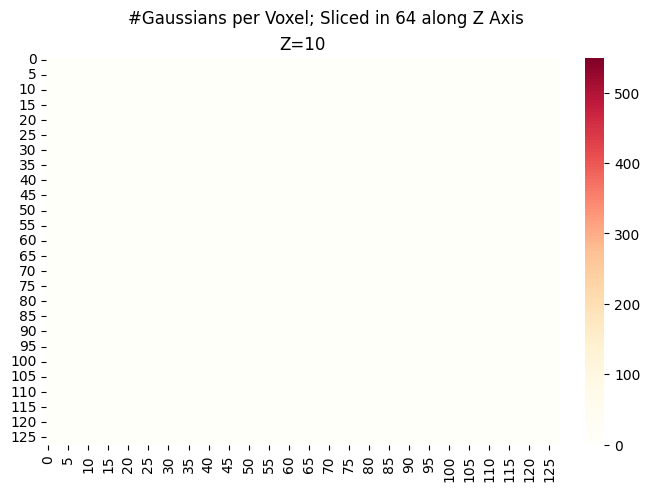

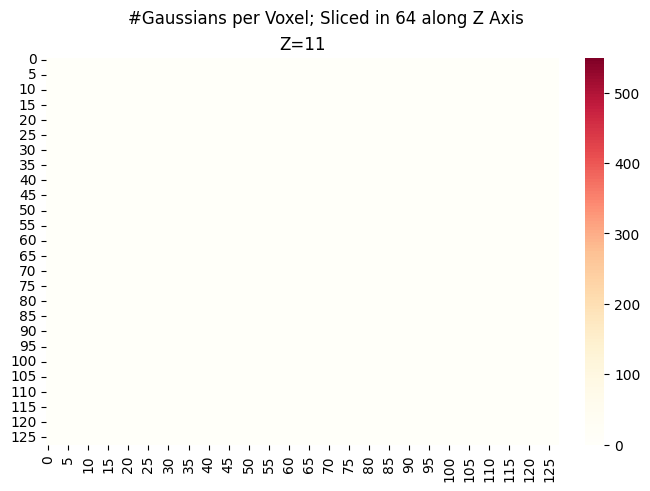

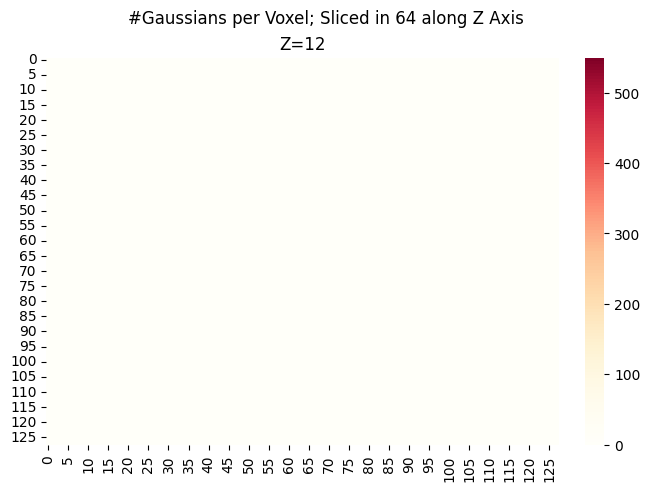

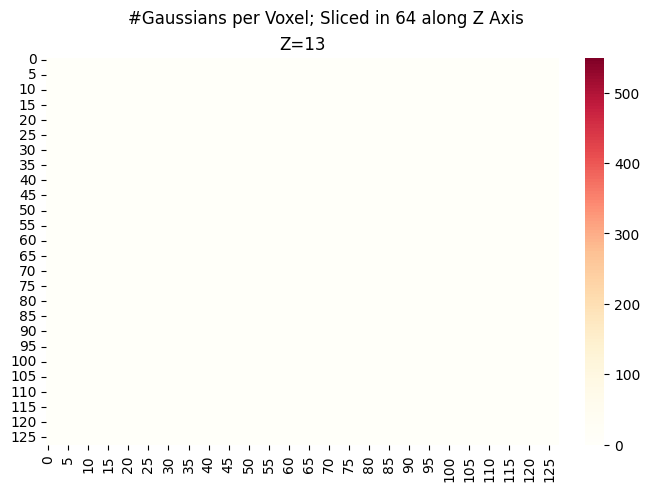

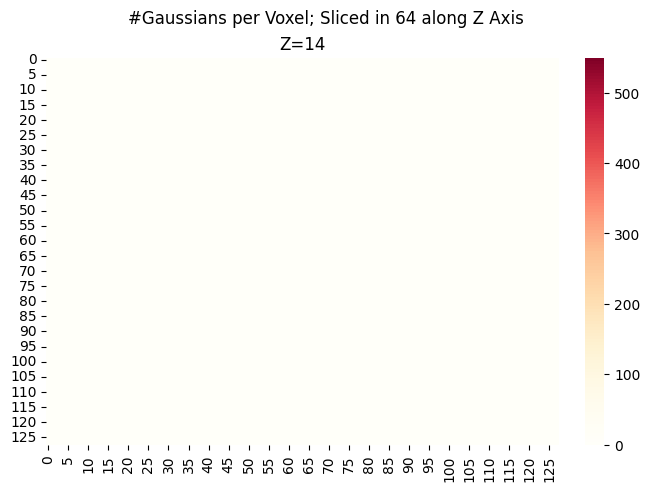

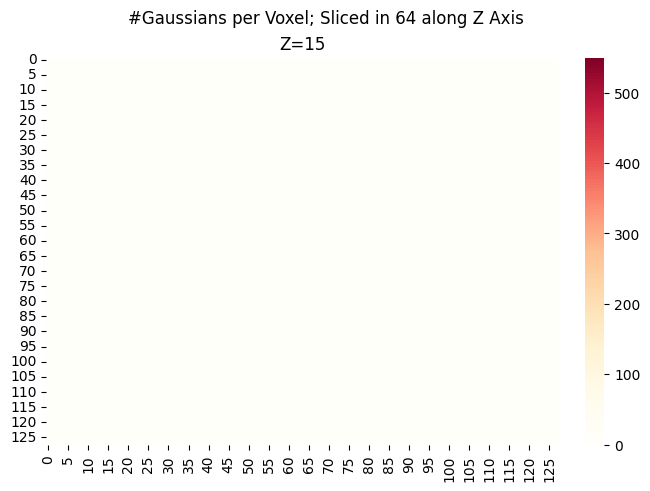

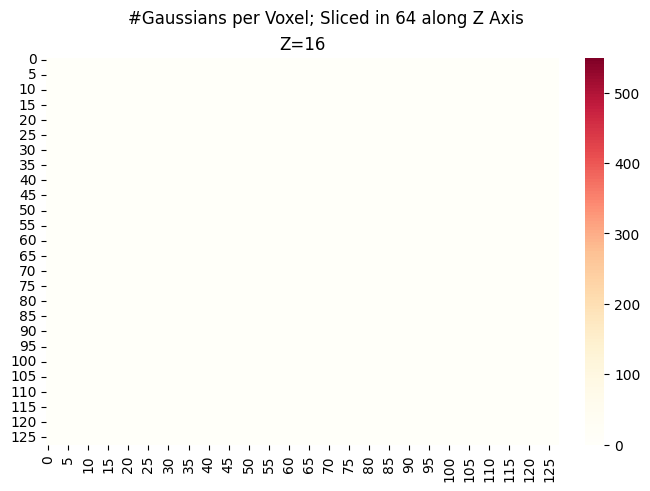

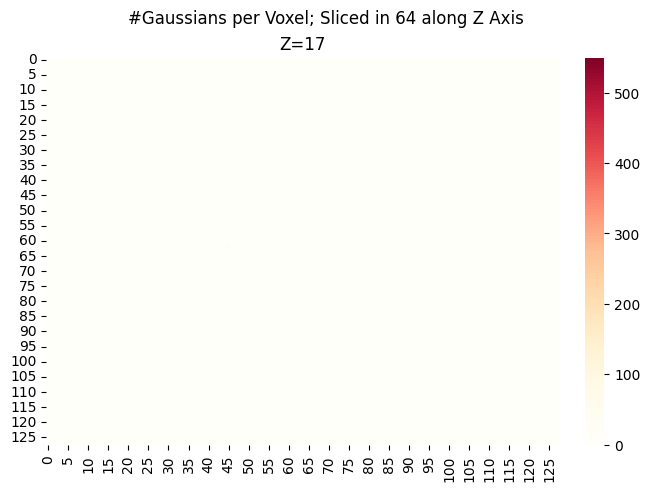

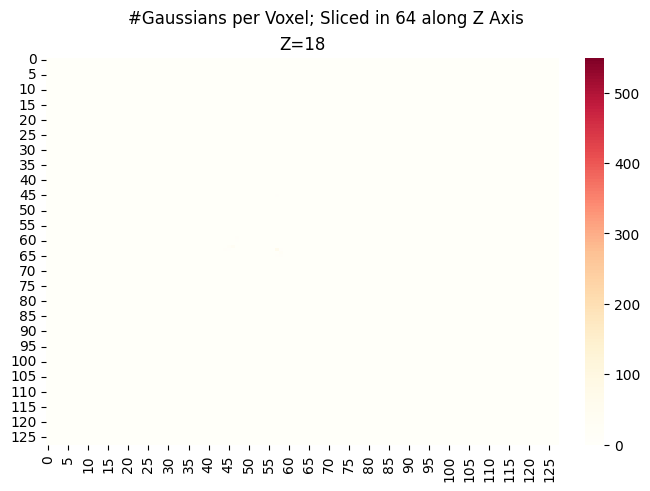

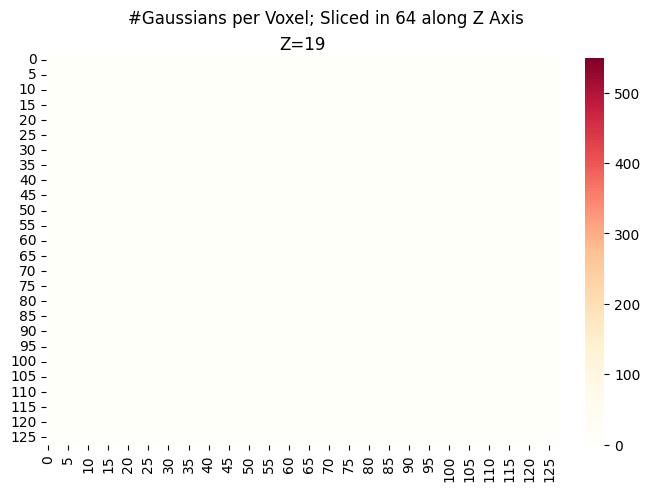

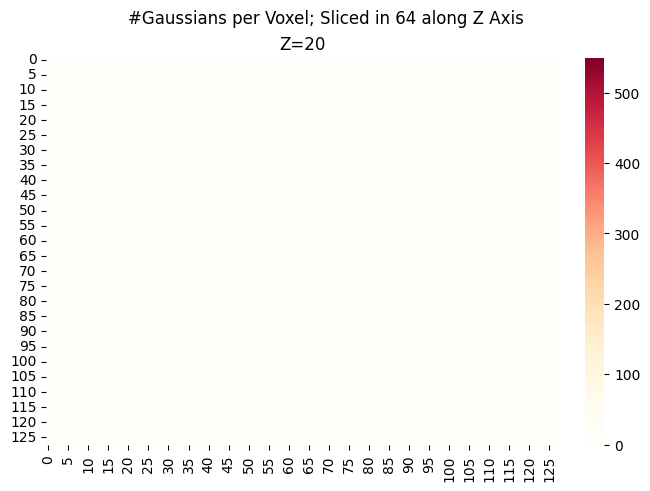

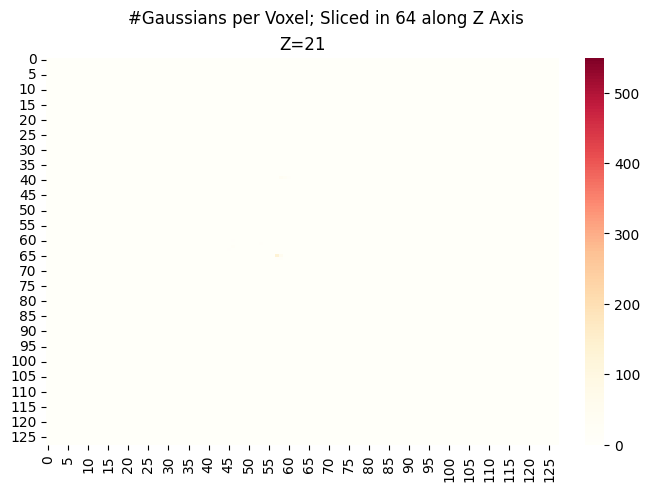

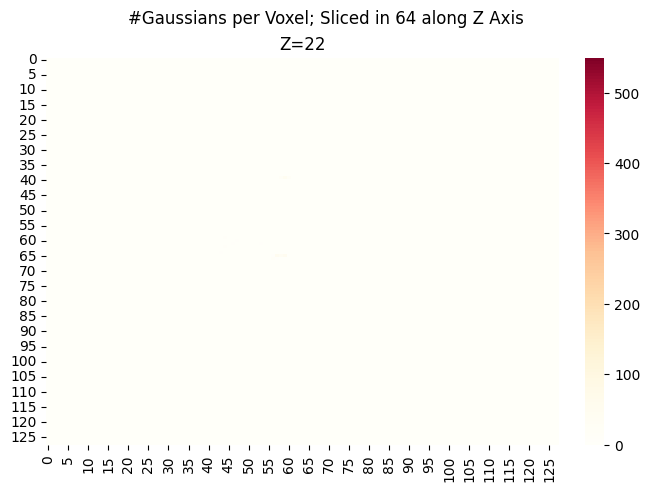

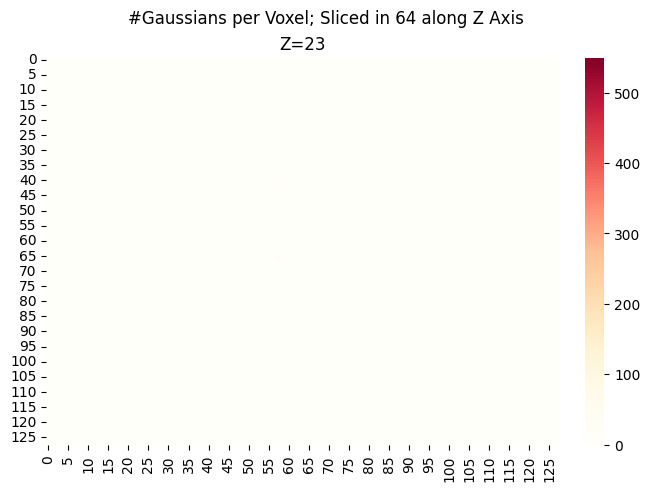

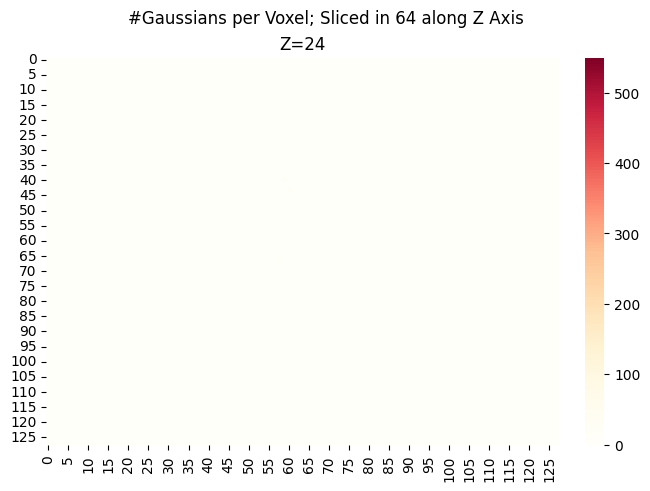

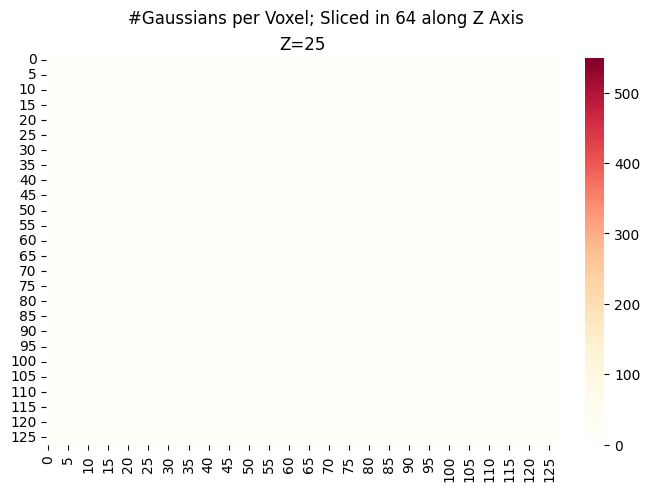

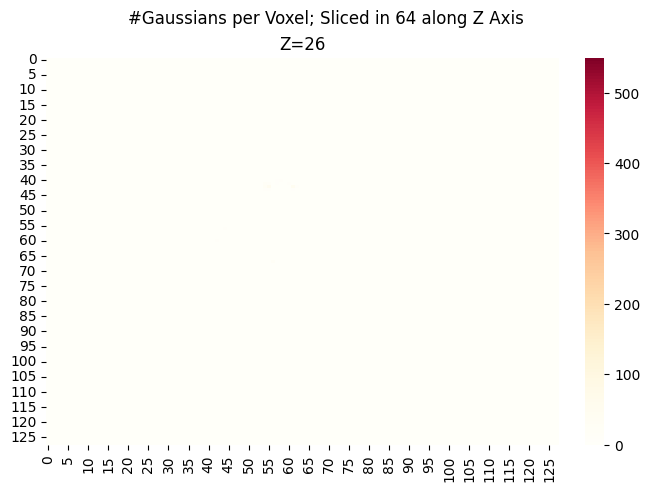

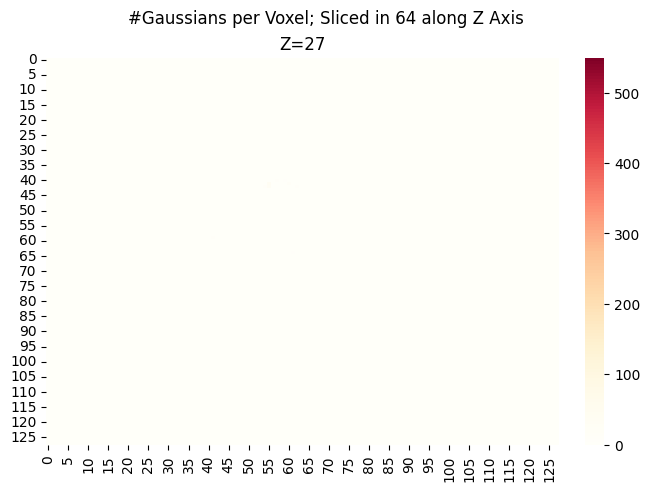

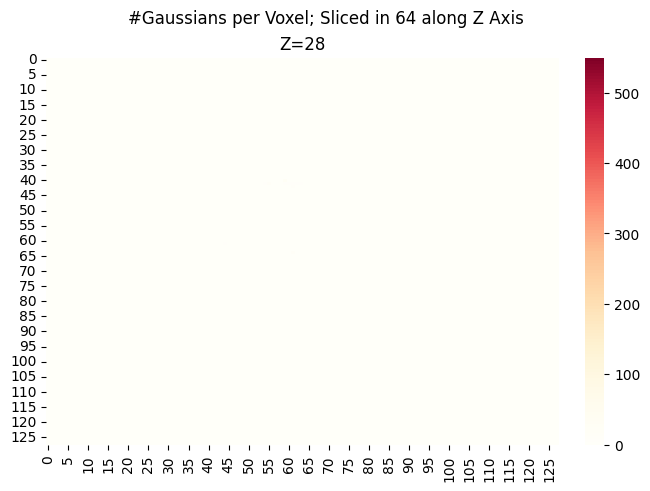

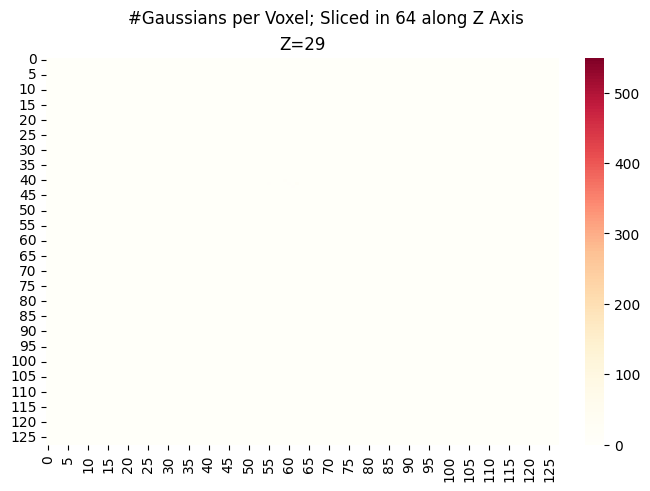

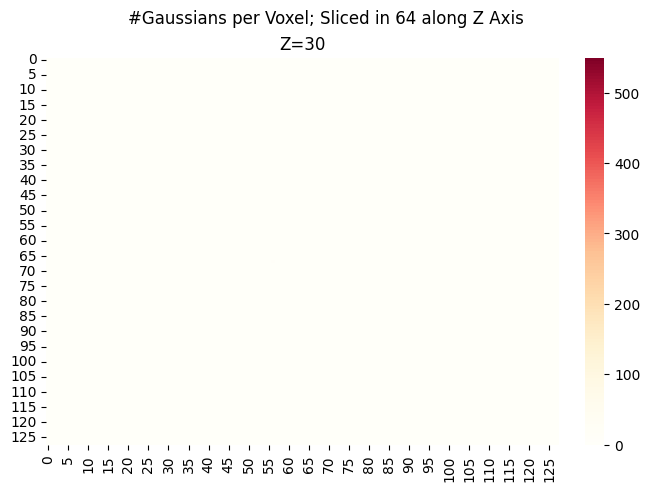

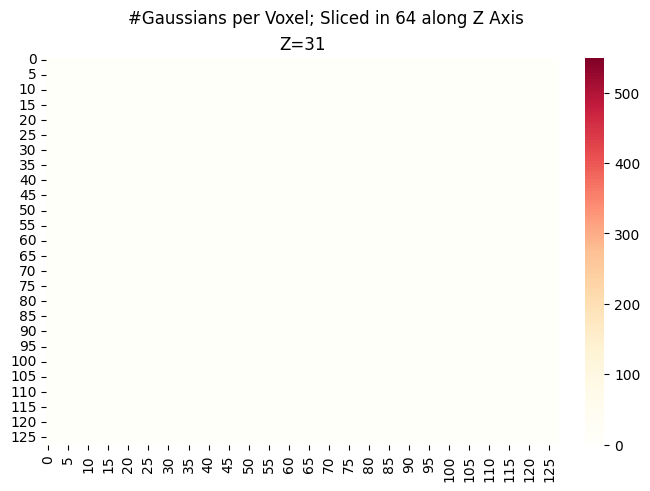

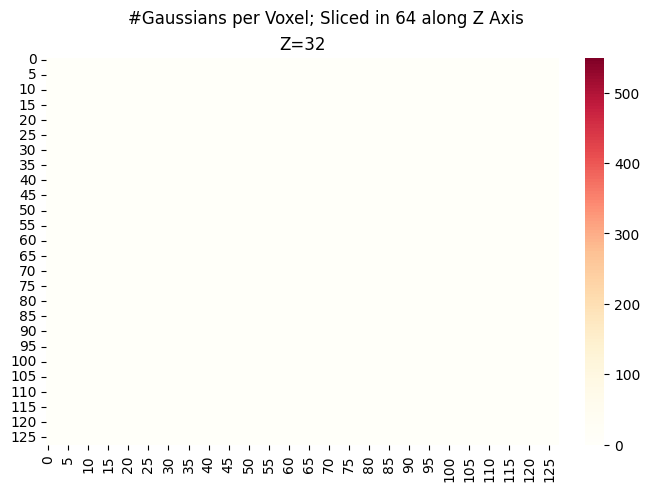

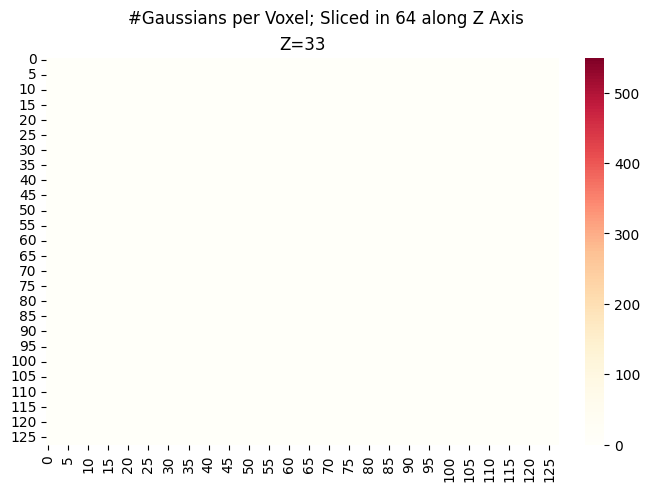

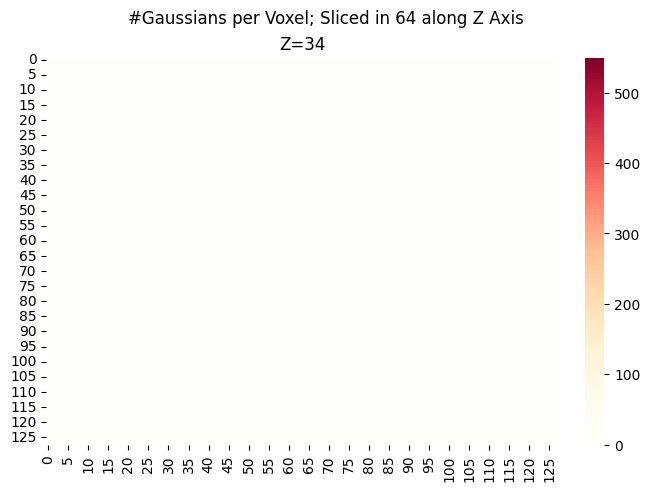

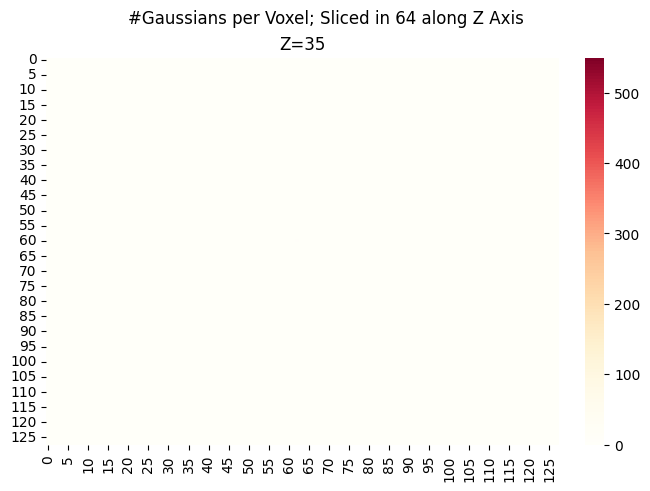

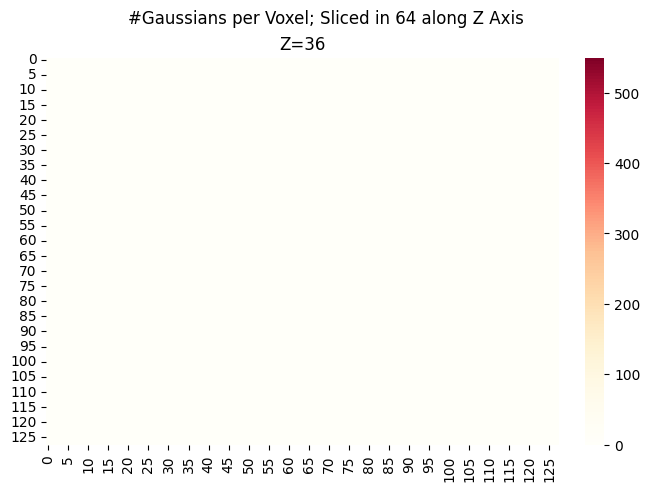

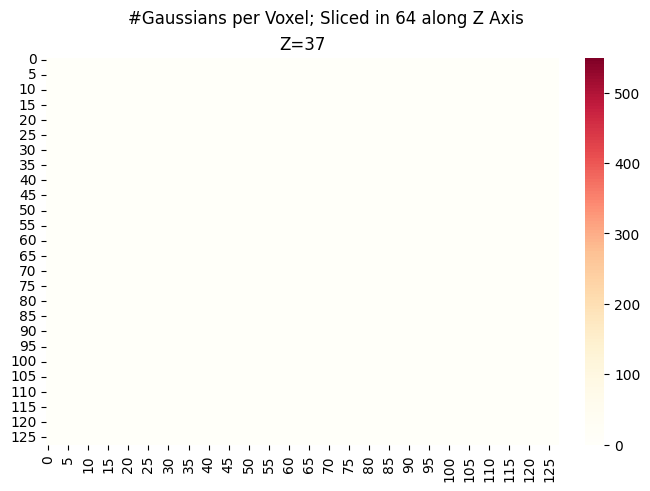

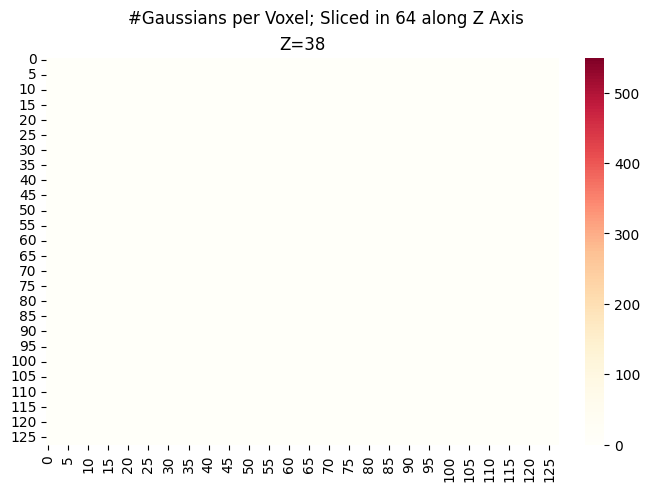

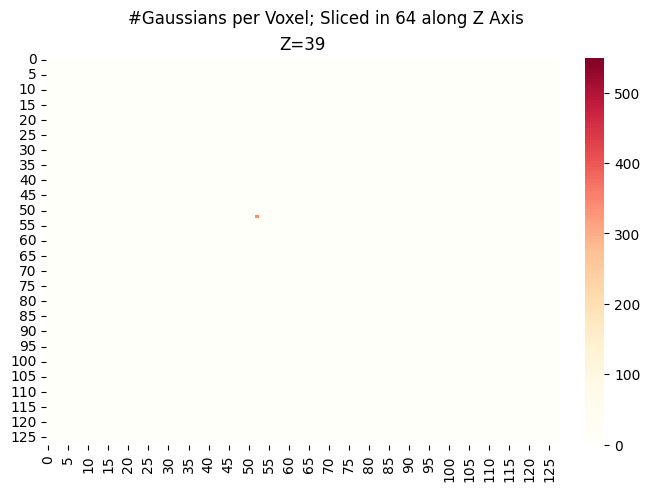

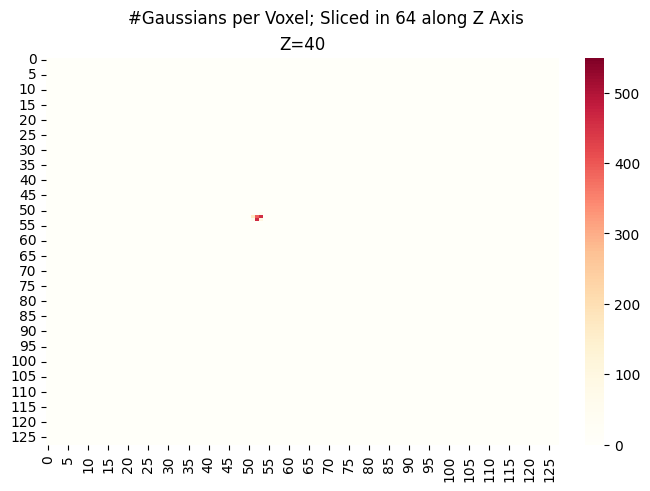

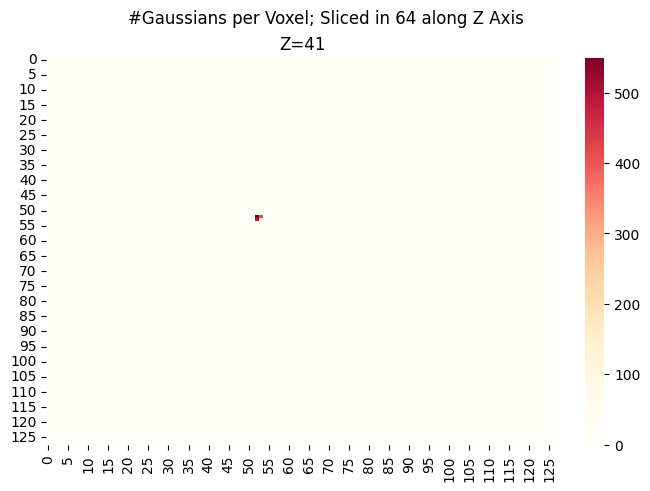

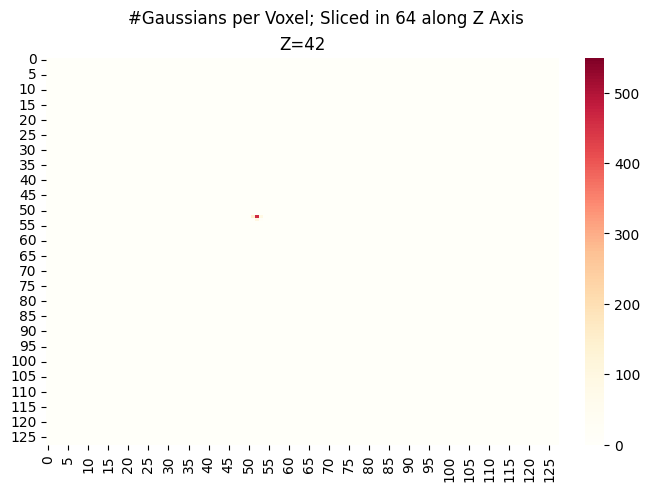

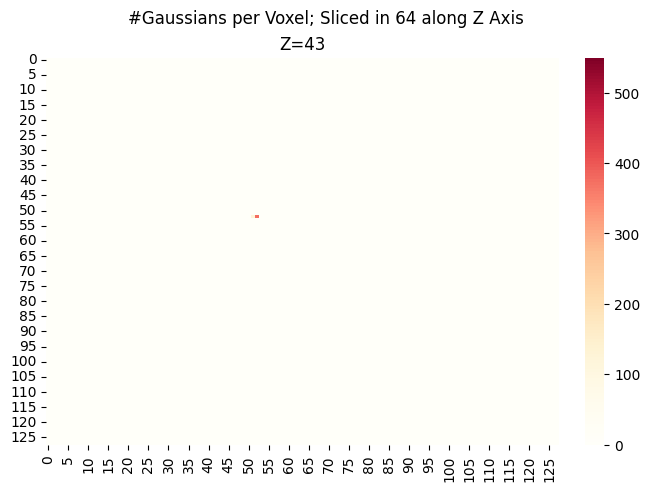

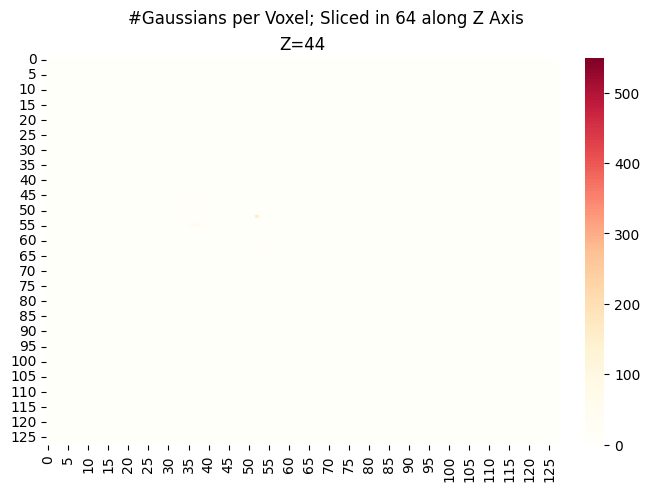

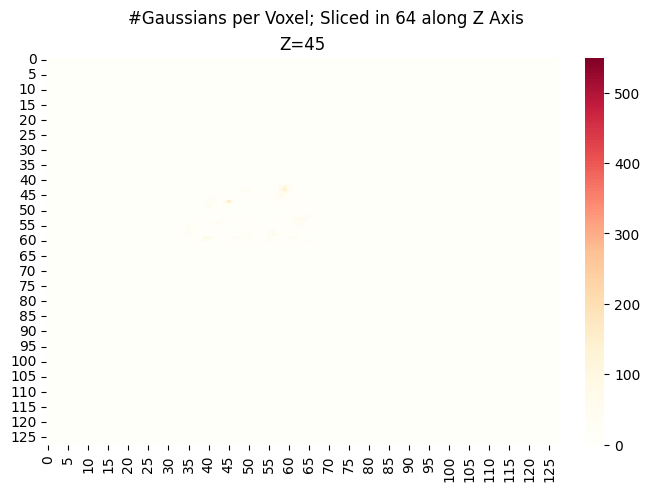

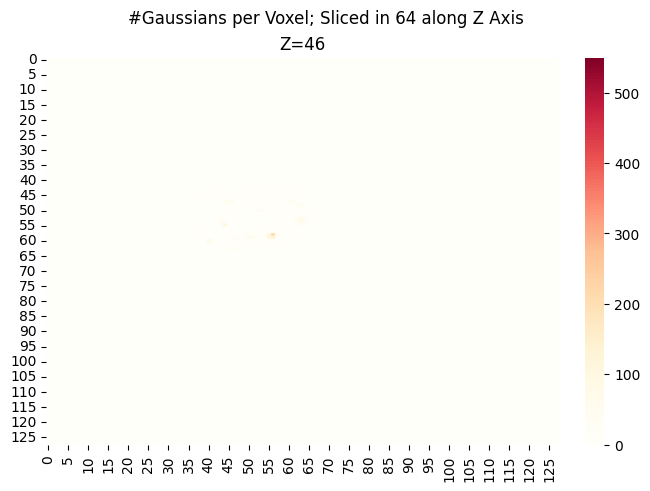

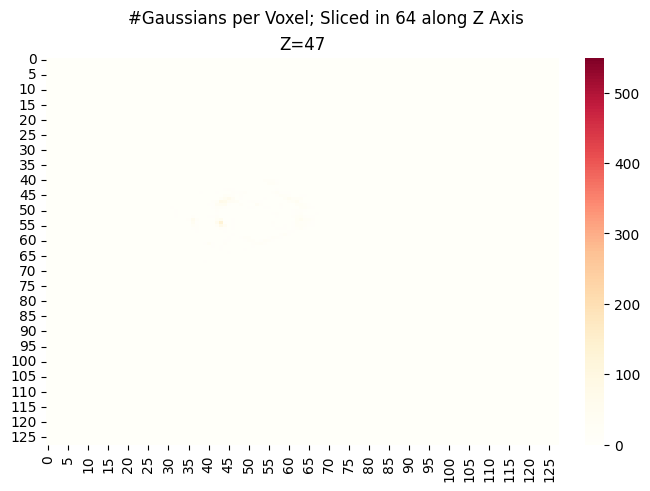

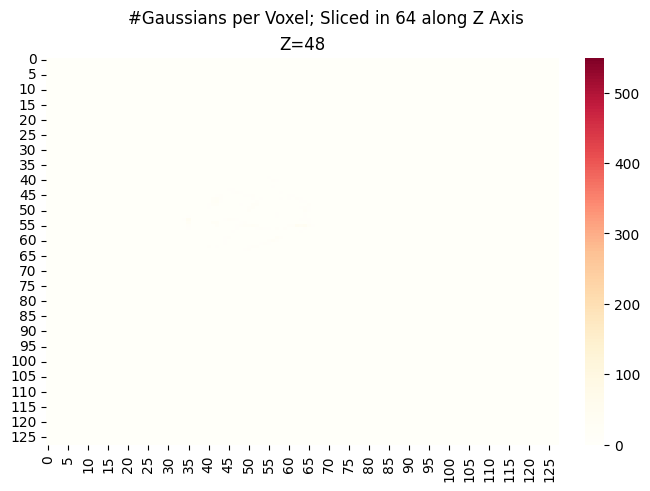

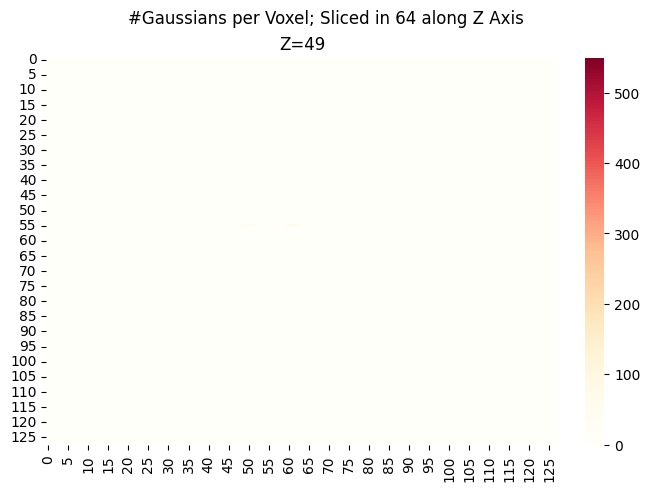

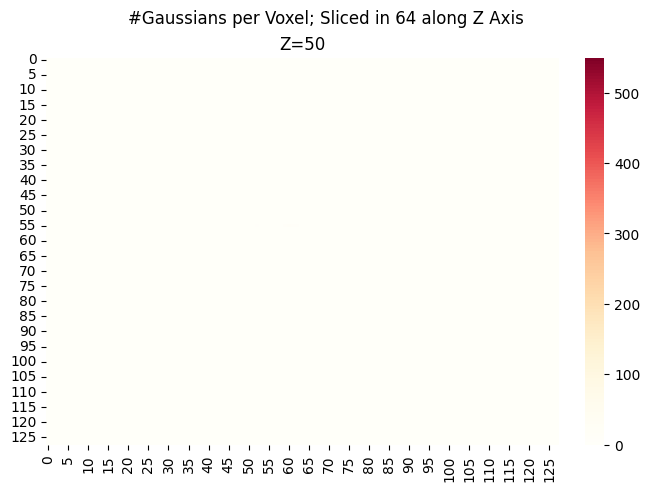

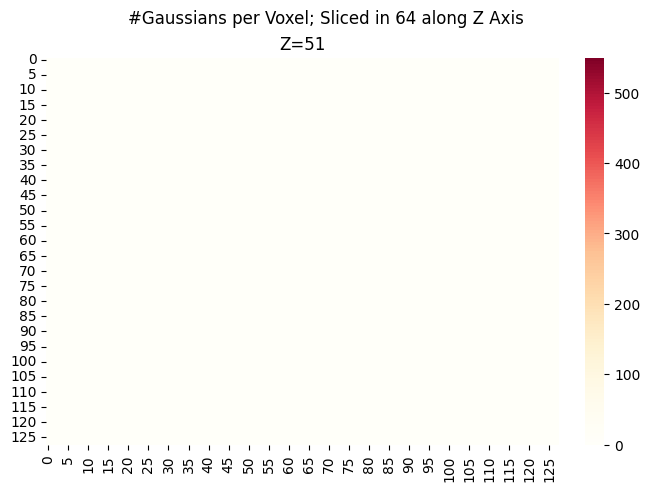

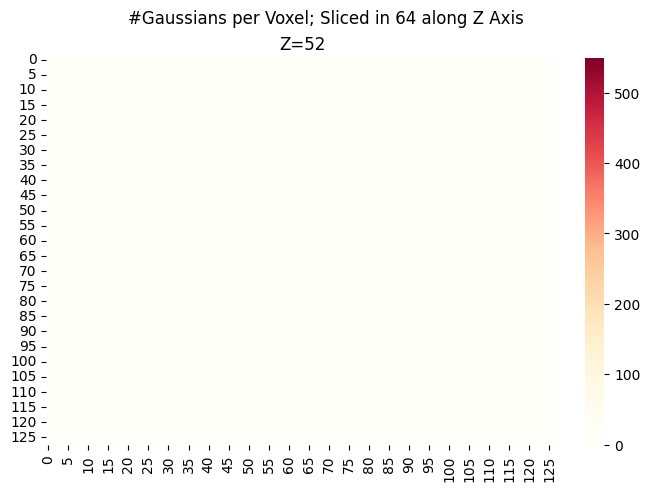

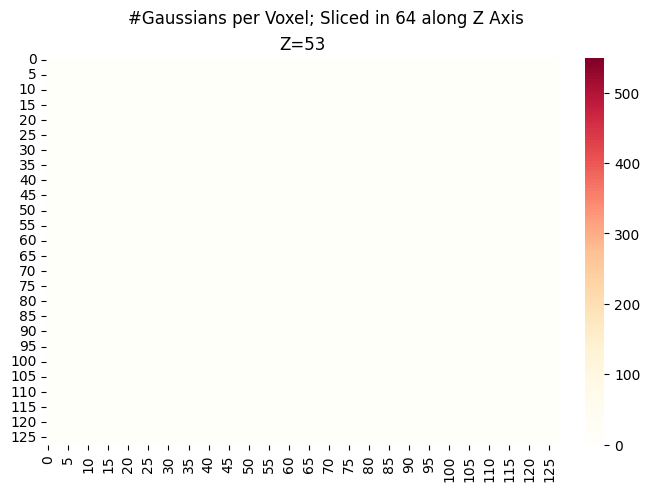

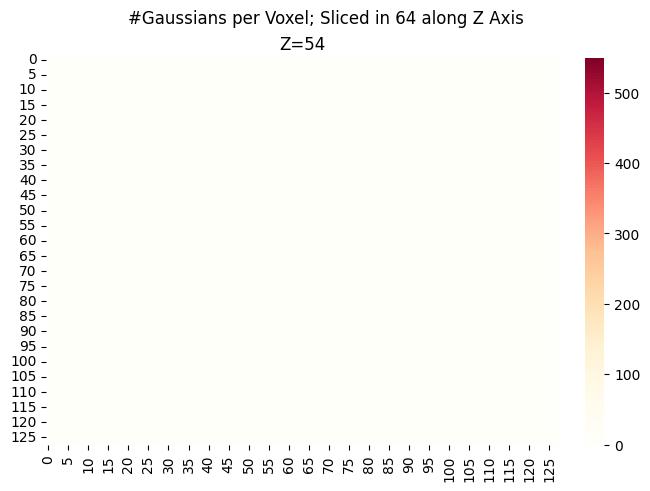

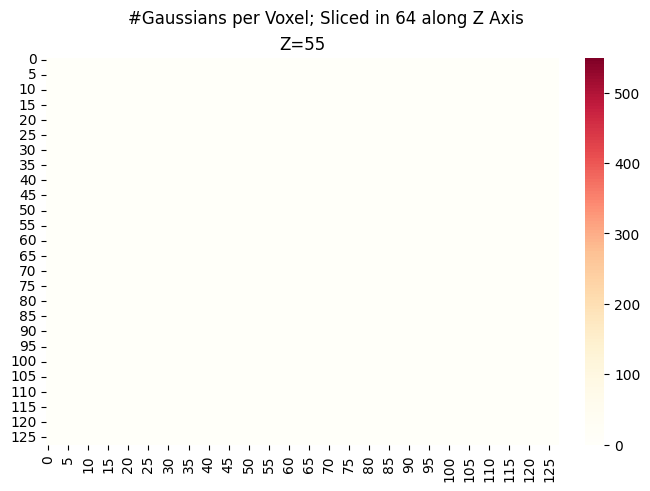

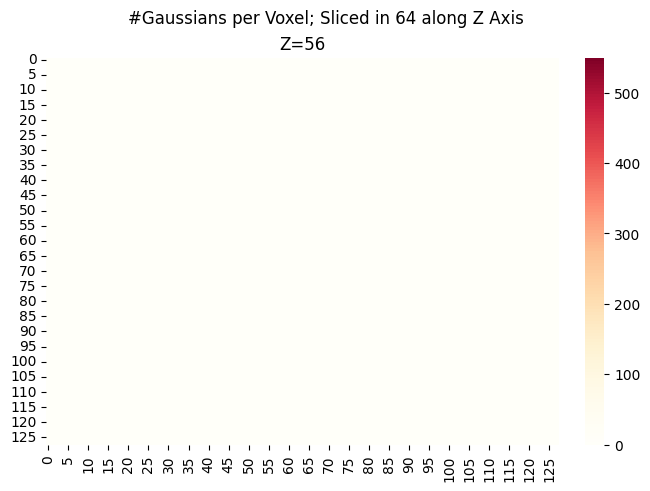

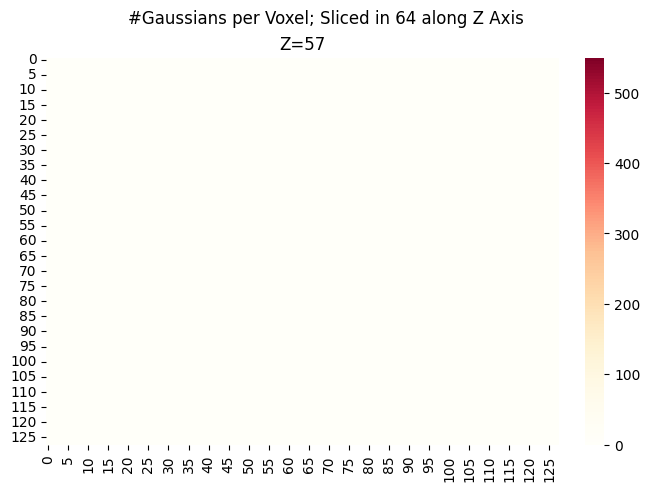

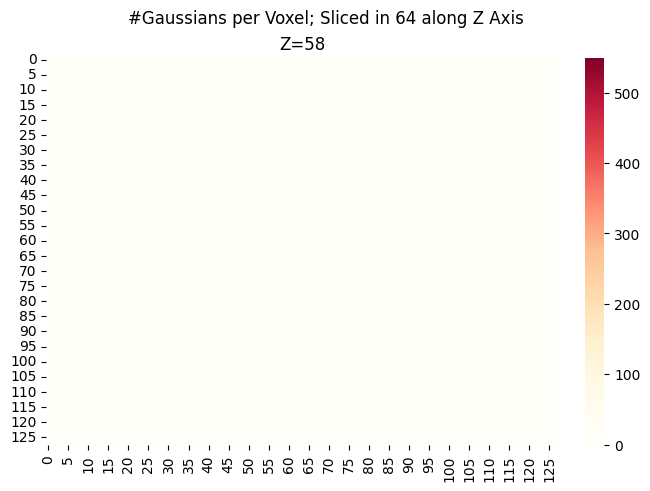

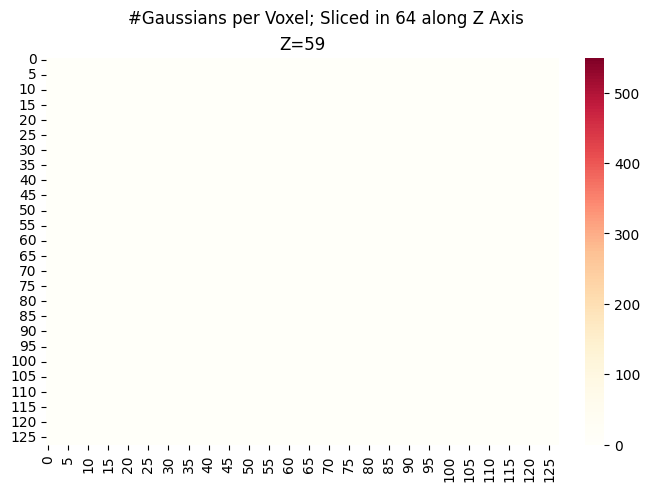

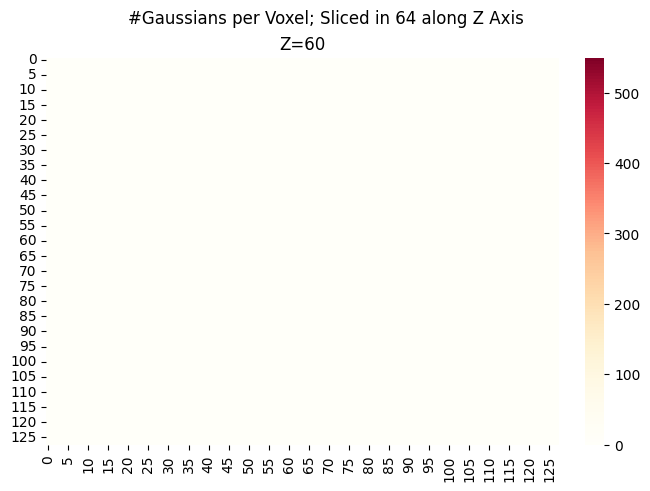

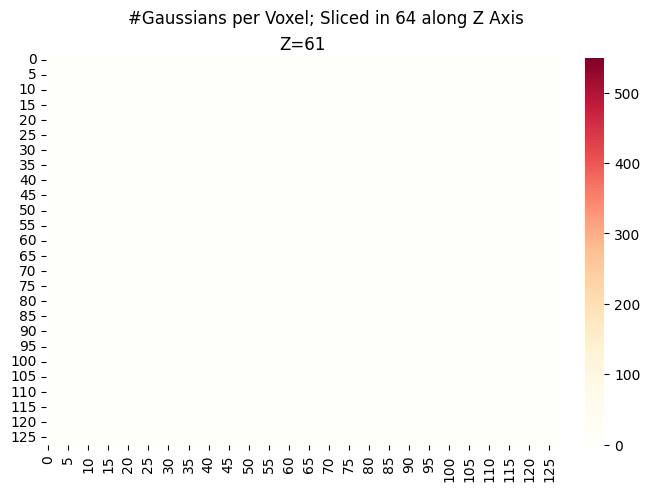

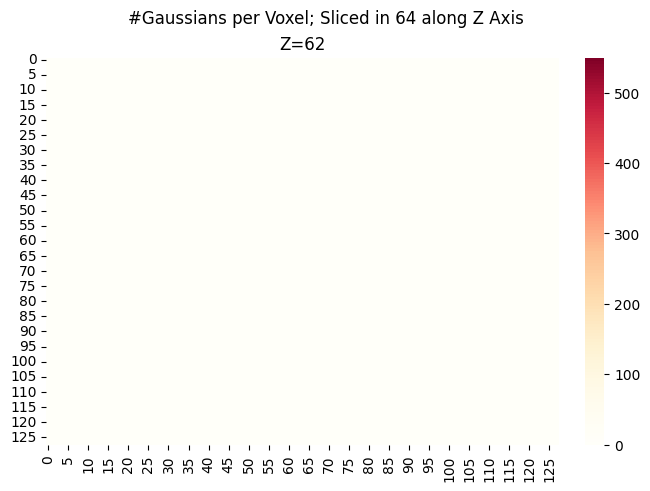

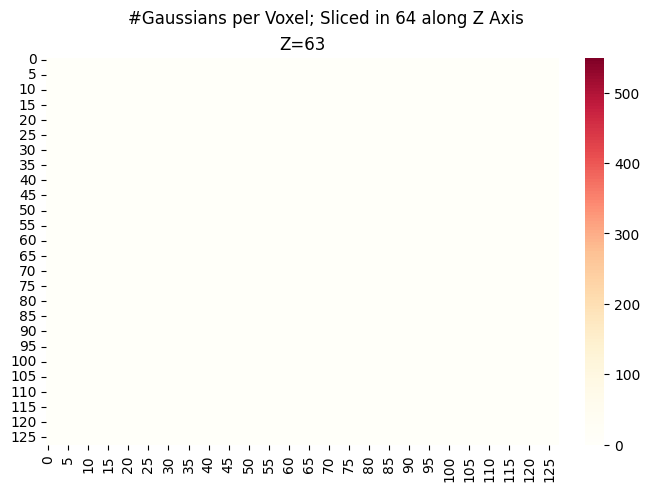

In [6]:

import os


@dataclass
class SliceAxis:
    name: str
    i: int
slice_axis = SliceAxis('Z', 2)


# fig =plt.figure(figsize=(8.5,11))
# fig.set_layout_engine('compressed')
# axs = fig.subplots(np.ceil(voxels.shape[slice_axis.i]/8).astype(int).item(), 8)
# for i, ax in zip(range(voxels.shape[slice_axis.i]), axs.flat):
for i in range(voxels.shape[slice_axis.i]):
    fig, ax = plt.subplots(1,1)
    fig.set_layout_engine('compressed')
    fig.suptitle(f"#Gaussians per Voxel; Sliced in {voxels.shape[slice_axis.i]} along {slice_axis.name} Axis")
    slice = voxels.take(i, slice_axis.i)
    sb.heatmap(slice,vmin=min,vmax=max,ax=ax,cmap=alpha_grad_cmap)
    ax.set_title(f'{slice_axis.name}={i}')
    fig.savefig(os.path.join(experiment_pretty_name,f'z={i}.svg'))